In [1]:
%matplotlib notebook
import os, sys, inspect, warnings
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
sub_dir = os.path.join(main_dir, 'RGCPD/')
# core_pp = os.path.join(main_dir, 'RGCPD/core')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(sub_dir)
import numpy as np
import math
from collections import Counter
# import statsmodels.api as sm 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (15.0, 8.0)
import itertools as it
import pywt as wv
from scipy.fftpack import fft
from copy import deepcopy
# from statsmodels.tsa.arima_process import  arma_generate_sample, ArmaProcess
from pprint import pprint as pp 
from pandas.plotting import register_matplotlib_converters
from RGCPD import RGCPD
from RGCPD import BivariateMI
from df_ana_class import DataFrameAnalysis, VisualizeAnalysis
import core_pp
from plot_signal_decomp import *
from plot_coeffs import * 
import wave_ana as wa 
register_matplotlib_converters()
plt.style.use('seaborn')

Could not import rpy package
Could not import r-package RCIT


# Preparing RGCPD data

In [2]:
path_data = os.path.join(main_dir, 'data')
current_analysis_path = os.path.join(main_dir, 'Jier_analysis')
target= 3
target_path = os.path.join(path_data, 'tf5_nc5_dendo_80d77.nc')
precursor_path = os.path.join(path_data,'sst_1979-2018_2.5deg_Pacific.nc')
list_of_name_path = [(target, target_path), 
                    ('sst', precursor_path )]
list_for_MI = [BivariateMI(name='sst', func=BivariateMI.corr_map, 
                          kwrgs_func={'alpha':.0001, 'FDR_control':True}, 
                          distance_eps=700, min_area_in_degrees2=5)]
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           start_end_TVdate=('06-01', '08-31'),
           path_outmain=os.path.join(main_dir,'Jier_analysis'))

## Setting up sampling frequency of RGCPD data

In [3]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)
rg.pp_TV()
rg.traintest(method='no_train_test_split')
rg.calc_corr_maps()
rg.cluster_list_MI()
rg.get_ts_prec(precur_aggr=1)

Loaded pre-processed data of sst

original tfreq of imported response variable is converted to desired tfreq 10
Daily input freq
No train test split

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(400dp, 100%)

redefine target variable on 1 day means
Selecting subset as defined by start_end_date
Daily input freq
No train test split

Getting MI timeseries
There are [2] regions in total (list of different splits)


## Defining tau_max and alpha

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


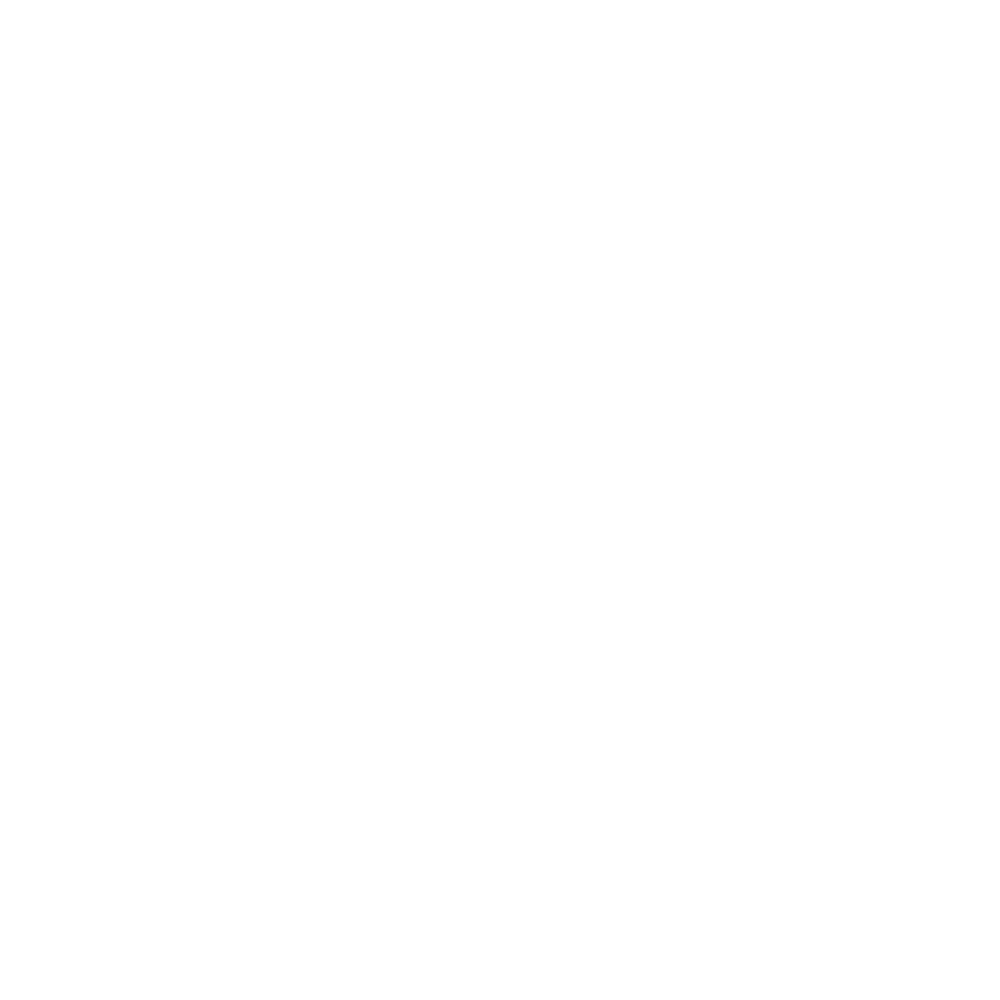

In [4]:
rg.PCMCI_df_data(tau_max=2, pc_alpha=0.05)
rg.PCMCI_get_links()
rg.df_MCIc
rg.PCMCI_plot_graph()

In [5]:
base_pmatrix = rg.pcmci_results_dict[0]['p_matrix']
mask_base_pmatrix = base_pmatrix < 0.05

In [6]:
mask_base_pmatrix

array([[[False,  True,  True],
        [ True, False, False],
        [ True,  True, False]],

       [[ True,  True, False],
        [False,  True,  True],
        [ True,  True, False]],

       [[ True,  True, False],
        [ True,  True,  True],
        [False,  True,  True]]])

## Extracting data from RG class

In [7]:
rg_data  = rg.df_data.loc[:,rg.df_data.columns[rg.df_data.dtypes != bool]]
rg_index = rg_data.index.levels[1]
if len(rg_data.columns[1:].tolist()) == 2:    
    prec1 = rg_data.iloc[:,1].values
    prec2 = rg_data.iloc[:,2].values
more_precursors = False 
if len(rg_data.columns[1:].tolist()) > 2:
    more_precursors = True
    prec_list = [rg_data.iloc[:,i]
      for i in range(1, len(rg_data.columns[1:].tolist())+1)
      if len(rg_data.columns[1:].tolist()) > 2 ]

target = rg_data.iloc[:,0].values

# Wavelet

## Wavelet choice

In [8]:
la8 = wa.create_least_asymmetric_filter(mode='dwt')
waves = ['sym2', 'sym4', 'sym8', la8]

In [9]:
def plot_dwt_default(data, w, title, level, mode, method='wavedec'):

    assert isinstance(w, wv.Wavelet)
    a = data
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print(f"Appropriate level is changed to {level}")
    else:
        level_ = None
        
    if method == 'coeff':
        plot_coeffs(data, w, mode, title, level)
        return
    elif method =='recon':
        plot_signal_decomp(data, w, mode, title, level)
    else:
        coeffs =  wv.wavedec(a, w, level=level, mode=mode)

        ylim = [a.min(), a.max()]

        fig, axes = plt.subplots(len(coeffs) + 1, figsize=(10, 8), constrained_layout=True)
        axes[0].set_title(title)
        axes[0].plot(a, 'k', label='Original signal')
        axes[0].set_ylabel(r'C$^{\circ}$')
        axes[0].set_xlim(0, len(a) - 1)
        axes[0].set_ylim(ylim[0], ylim[1])
        axes[0].legend(loc=0)

        for i, _ in enumerate(coeffs):
            ax = axes[-i - 1]
            if i == 0:
                ax.set_ylabel("A%d" % (len(coeffs) - 1))
                ax.plot( coeffs[i], 'r')
            else:
                ax.set_ylabel("D%d" % (len(coeffs) - i))
                ax.plot( coeffs[i], 'g')
            # Scale axes
#             ax.set_xlim(0, len(a) - 1)
#             ax.set_ylim(ylim[0], ylim[1])
#         plt.tight_layout(pad=1.8, h_pad=1.9)
#         plt.subplot_tool()

Appropriate level is changed to 11


<IPython.core.display.Javascript object>


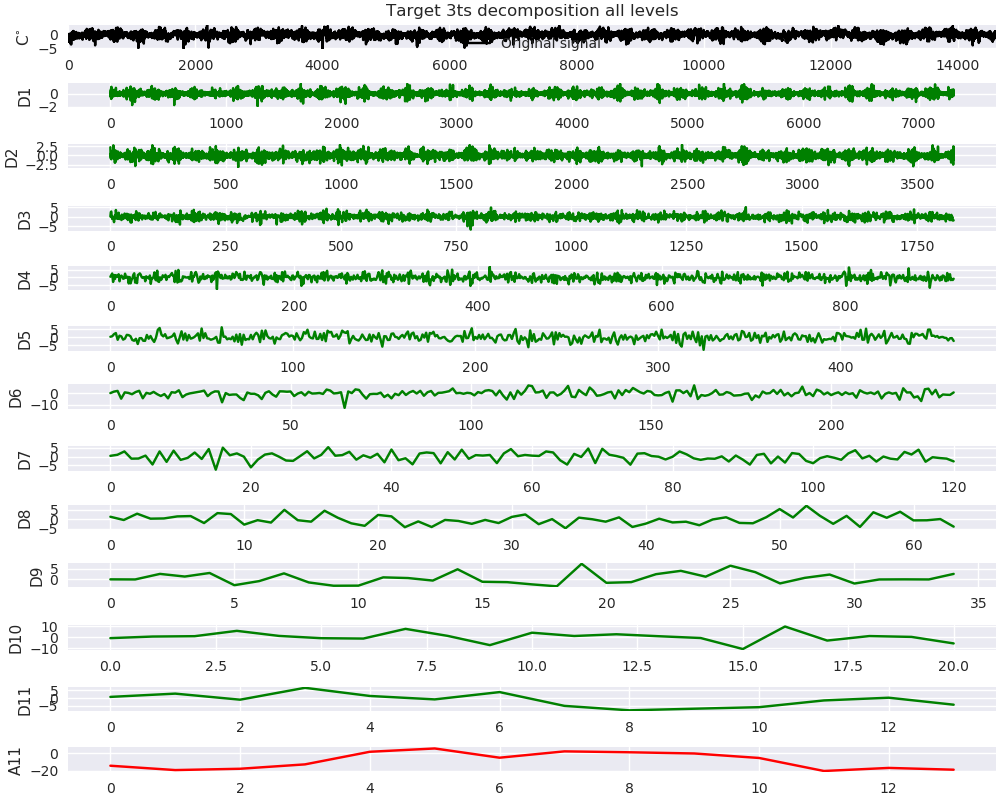

In [80]:
plot_dwt_default(target, w=la8, title=f'Target {rg_data.iloc[:,0].name} decomposition all levels', level=15, mode=wv.Modes.periodic)

Appropriate level is changed to 11


<IPython.core.display.Javascript object>


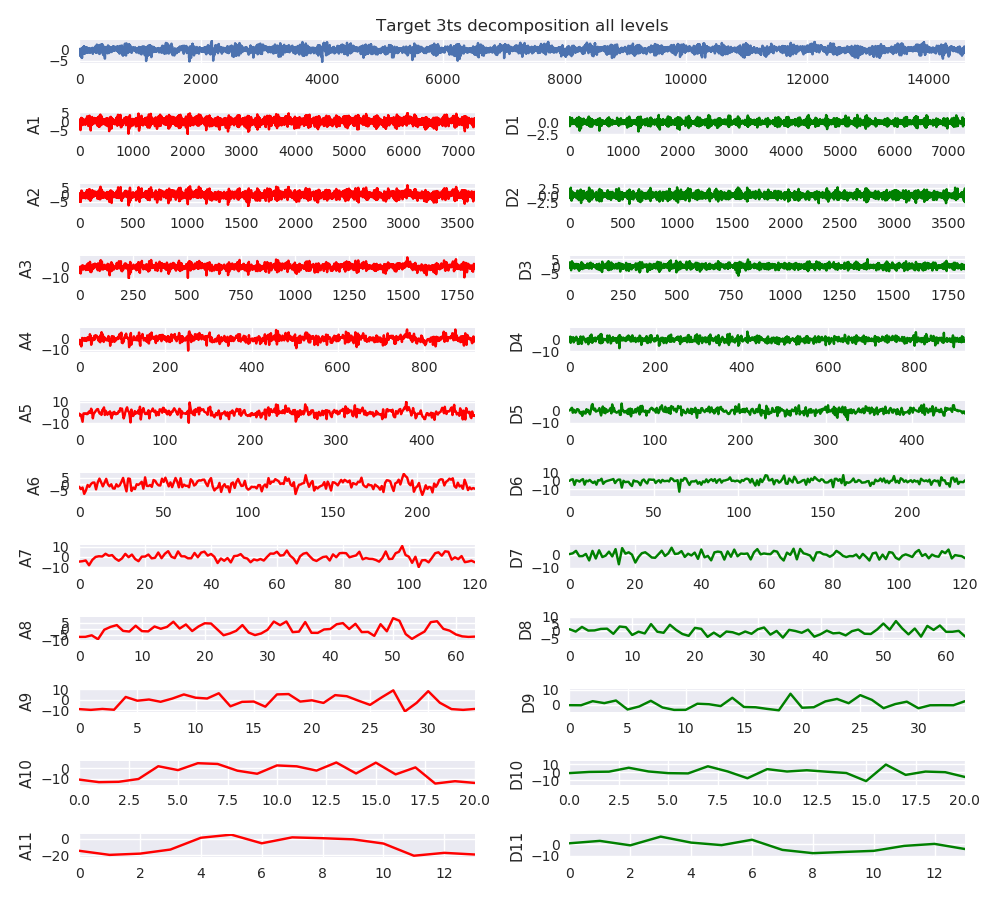

In [79]:
plot_dwt_default(target, w=la8, title=f'Target {rg_data.iloc[:,0].name} decomposition all levels', level=15, mode=wv.Modes.periodic, method="coeff")

Appropriate level is changed to 11


<IPython.core.display.Javascript object>


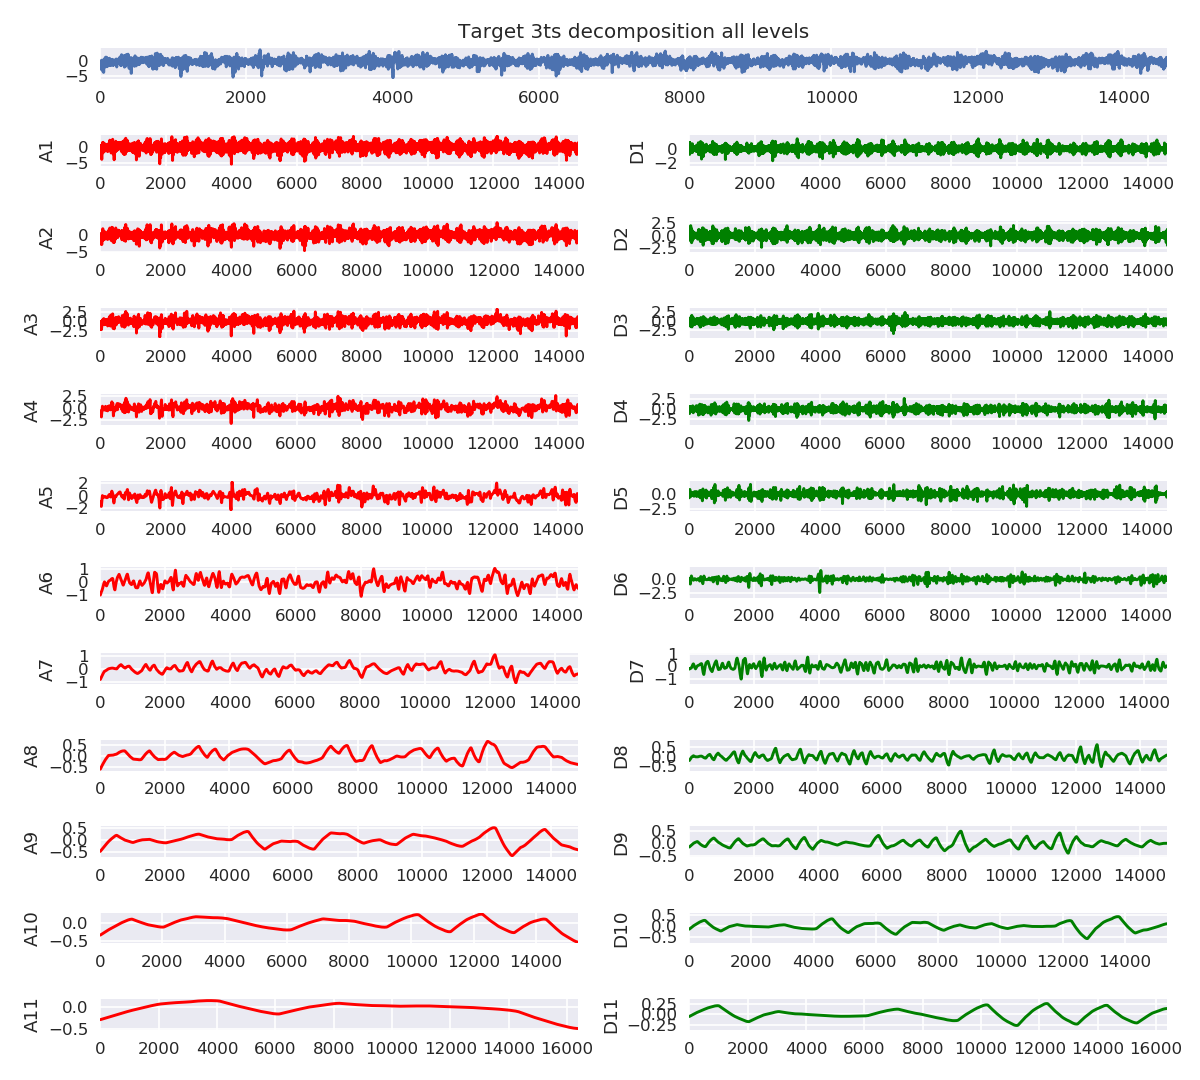

In [78]:
plot_dwt_default(target, w=la8, title=f'Target {rg_data.iloc[:,0].name} decomposition all levels', level=15, mode=wv.Modes.periodic, method="recon")

## Decompose and reconstruct signal

In [109]:
def decompose_signal(data, w, mode, level, debug=False):
    assert isinstance(w, wv.Wavelet)
    cA, cD = [] , []
    s_prec  = data 
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print(f"Appropriate level is changed to {level}")
    else:
        level_ = None
    for i in range(level):
        s_prec, det  = wv.dwt(s_prec, w, mode=mode)
        cA.append(s_prec)
        cD.append(det)
    if debug:
        print(f'[DEBUG]')
        for i, value in enumerate(cD):
            print(f' Level {i} decomposition Length coefficient {value}')
    return cA, cD, level 

In [151]:
def reconstruct_signal(data, w, mode, level, debug=False):
    """Decompose and reconstruct S.
    S = An + Dn + Dn-1 + ... + D1
    """
    assert isinstance(w, wv.Wavelet)
    a = data
    ca = []
    cd = []
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print("Appropriate level is changed to ", level)
    else:
        level_ = None 
    for i in range(level):
        (a, d) = wv.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(wv.waverec(coeff_list, w, mode=mode))
        print(f'Length reconstruction approx  index {len(coeff_list)} length coeffs {len(coeff)} length recon {len(rec_a[i])}')

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(wv.waverec(coeff_list, w, mode=mode))
    return rec_a, rec_d, ca, cd

In [152]:
reconstruct_signal(target,la8, wv.Modes.periodic,16,  debug=True)

Appropriate level is changed to  11
Length reconstruction approx  index 2 length coeffs 7303 length recon 14600
Length reconstruction approx  index 3 length coeffs 3655 length recon 14602
Length reconstruction approx  index 4 length coeffs 1831 length recon 14606
Length reconstruction approx  index 5 length coeffs 919 length recon 14614
Length reconstruction approx  index 6 length coeffs 463 length recon 14630
Length reconstruction approx  index 7 length coeffs 235 length recon 14662
Length reconstruction approx  index 8 length coeffs 121 length recon 14726
Length reconstruction approx  index 9 length coeffs 64 length recon 14854
Length reconstruction approx  index 10 length coeffs 35 length recon 14854
Length reconstruction approx  index 11 length coeffs 21 length recon 15366
Length reconstruction approx  index 12 length coeffs 14 length recon 16390


([array([-0.77038776, -2.17368122, -2.40652949, ..., -0.47872839,
          0.56799582,  0.97194418]),
  array([-0.55703713, -1.53022047, -2.21418224, ..., -0.26243758,
         -0.29703718, -0.33008927]),
  array([-1.25164648, -1.42601122, -1.61894487, ..., -0.81697764,
         -0.71914777, -0.60042968]),
  array([-1.45017026, -1.51139787, -1.55336569, ..., -0.82885775,
         -0.77864712, -0.71536685]),
  array([-0.87721855, -0.89963113, -0.92393367, ..., -0.67771725,
         -0.66137722, -0.64096743]),
  array([-1.02522299, -1.02856216, -1.03041365, ..., -0.51102774,
         -0.50748605, -0.50339104]),
  array([-0.824571  , -0.82345991, -0.82178204, ..., -0.38360874,
         -0.38302864, -0.38248225]),
  array([-0.62006003, -0.61870787, -0.61716626, ..., -0.40256309,
         -0.40277547, -0.40298515]),
  array([-0.47393741, -0.47285807, -0.47170909, ..., -0.40729364,
         -0.40744279, -0.40758182]),
  array([-0.34311469, -0.34268663, -0.34224409, ..., -0.5409905 ,
       

In [15]:
def extract_signal_at_level(original_signal, signal, level):
    assert len(signal[level]) <= len(original_signal), f"[ERROR] Wavelet introduce longer signal length at given level {len(signal[level])} vs data length {len(original_signal)} "
    return signal[level] if level <= len(signal) else None

In [16]:
def check_correct_level_extracted(ex_signal, signal, level):
    assert level != len(signal), "Array start at 0, so do not confuse level decomp and length of signal\n"
    return np.array_equiv(ex_signal, signal[level])

In [110]:
t_ca, t_cd,_ = decompose_signal(data=target, w=la8, mode=wv.Modes.periodic, level=15)

Appropriate level is changed to 11


In [18]:
ex_td_11 = extract_signal_at_level(original_signal=target, signal=t_cd, level=10)
ex_ta_11 = extract_signal_at_level(original_signal=target, signal=t_ca, level=10)

In [19]:
print(type(ex_ta_11))

<class 'numpy.ndarray'>


In [20]:
d_11 = check_correct_level_extracted(ex_td_11, t_cd, 10)
a_11 = check_correct_level_extracted(ex_ta_11, t_ca, 10)
print(a_11, d_11)

True True


### Useless to use reconstructed coeffs to build signal again, use directly coeffs

In [22]:
# Last level decomposition introduces more signal not to use or dependant on mode??
what = wv.waverec([ex_ta_11, None]+[None]*10, la8, wv.Modes.periodic)

In [23]:
what.__len__()

16390

In [24]:
wv.waverec([ex_ta_11, ex_td_11], la8, wv.Modes.periodic).size

22

In [381]:
# # Expect only specific format to reconstruct signal
s  = [1,2,3,4,5,6,7,8]
coeffs = wv.wavedec(s, 'db1', level=2)
print(f'{coeffs}, len {len(coeffs)}\n')
temp0 = wv.idwt(coeffs[0],None, "db1")
temp1 = wv.waverec([coeffs[0], coeffs[1]], "db1")
temp2 = wv.waverec(coeffs, 'db1')
print(f"level 0 recon {temp0}\n level 1 recon {temp1}\n full level {temp2}")
# (ca, cd) = coeffs
# print(wv.upcoef('a', ca, 'db1', take=len(s))+wv.upcoef('d', cd, 'db1', take=len(s)))

[array([ 5., 13.]), array([-2., -2.]), array([-0.70710678, -0.70710678, -0.70710678, -0.70710678])], len 3

level 0 recon [3.53553391 3.53553391 9.19238816 9.19238816]
 level 1 recon [ 2.12132034  4.94974747  7.77817459 10.60660172]
 full level [1. 2. 3. 4. 5. 6. 7. 8.]


In [26]:
# This is utter bullshit, just do not use this method 
# wv.dwt(temp2,'db1');

# Reconstruction introduces artefact in reconstructed signal length, need to take into account
# rec_ta[5].__len__();

In [27]:
# np.array_equiv(t_ca[-2], t_ca[9])

In [28]:
 # introduce artifact fillers dont use to reconstruct
# x_test = wv.upcoef('a', ex_ta_11, la8, take=len(target))+wv.upcoef('d', ex_td_11, la8, take=len(target))

In [29]:
# x_test.__len__()

In [30]:
# This is another bullshit not to do. 
# new_x_test = wv.upcoef('a', ex_ta_11, la8,level=11, take=len(target))+wv.upcoef('d', ex_td_11, la8, level=11, take=len(target))

In [31]:
# new_x_test.__len__()

In [32]:
# %matplotlib notebook
# plt.plot(new_x_test, 'g')
# plt.plot(target, 'r')
# plt.show()

In [33]:
# x_test_ = wv.idwt(ex_ta_11, ex_td_11, la8, wv.Modes.periodic)

# x_test_.__len__()

# np.array_equiv(x_test, x_test_)

In [34]:
# waverec and idwt equivalent way to reconstruct signal as waverec uses idwt under the hood
# x_test__ = wv.waverec(tuple((ex_ta_11, ex_td_11)), la8, wv.Modes.periodic)

In [35]:
# x_test__.__len__()

In [36]:
# %matplotlib notebook
# plt.plot(x_test, 'r')
# plt.plot(x_test_, 'g')
# plt.plot(x_test__, 'b')
# plt.show()

In [37]:
# p = [t_ca[-1], *t_cd[:-1]]
# # wv.upcoef('a', t_ca[9], la8, take=len(target)) + wv.upcoef('d', t_cd[9], la8, take=len(target))
# arr, coeff_slices = wv.coeffs_to_array(p)
# coeffs_from_arr = wv.array_to_coeffs(arr, coeff_slices,output_format='wavedec')
# # wv.waverec(np.array(list(zip(t_ca, t_cd))), wavelet=la8, mode=wv.Modes.periodic) # Not what you want
# # wv.waverec(coeffs_from_arr, la8, mode=wv.Modes.periodic) #Does not work shape mismatch

# # This only builds up at the level given and does not build up up to begin decomposition
# test0 = wv.idwt(coeffs_from_arr[0], None, la8, wv.Modes.periodic)
# test1 = wv.idwt(None, coeffs_from_arr[-1], la8, wv.Modes.periodic)
# print(np.array_equal(test0, test1), len(test0), len(test1))

False 22 36


### Manoeuvring to extract the ith level for target and the rest for precursor

In [ ]:
coeffs = wv.wavedec(target, la8, mode=wv.Modes.periodic, level=11)

In [158]:
coeffs.__len__()

12

In [159]:
print(coeffs[-12], len(coeffs[-12]))
coeffs[-12] = np.zeros_like(coeffs[-12])
print(coeffs[-12], len(coeffs[-12]), len(ex_ta_11), len(ex_td_11))

[-14.42486766 -19.39279115 -17.88405746 -12.89907092   1.47001023
   5.23738858  -5.28504344   1.93943856   0.89864498  -0.46251288
  -5.58432523 -20.42832702 -16.93348409 -18.96120352] 14
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 14 14 14


In [160]:
rec_tar = wv.waverec(coeffs, la8, mode=wv.Modes.periodic)

In [161]:
rec_tar.__len__()

14600

<IPython.core.display.Javascript object>


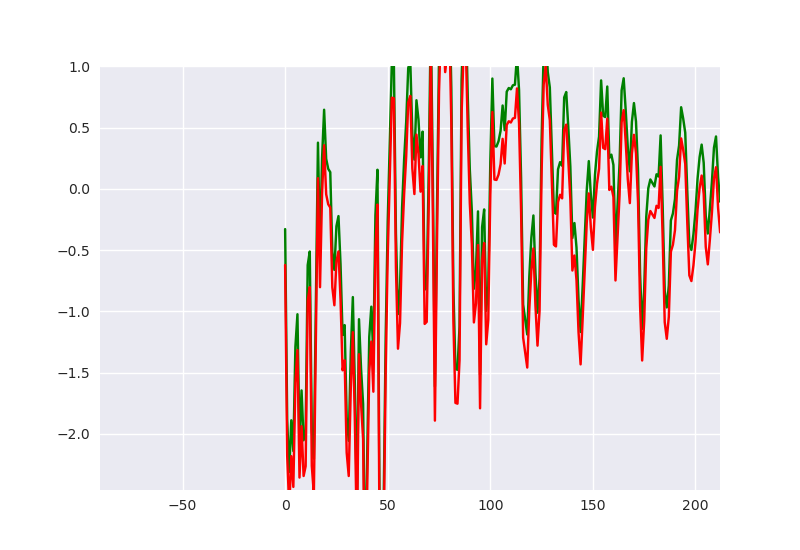

In [162]:
%matplotlib notebook
plt.plot(rec_tar, 'g')
plt.plot(target, 'r')
plt.show()

In [52]:
def build_up_to_level(data, w, mode, level, to_omit_level):
    print('[INFO] Know that to_omit_level needs to be 1 indexed instead of 0 indexed')
    
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print("[INFO] Appropriate level is changed to ", level)
    else:
        level_ = None 
        
    coeffs  = wv.wavedec(data, w, mode, level)
    print(f'[INFO] Length decomposed coefficients is {len(coeffs)}')
    
    assert to_omit_level+1 <= len(coeffs), f"[ERROR] To omit level need to be  strictly less than decomposition {level} and len coeffs {len(coeffs)}"
    coeffs[-to_omit_level+1] = np.zeros_like(coeffs[-to_omit_level+1])
    return wv.waverec(coeffs, w, mode)

In [44]:
def get_precursor_from_target_decomposition(low_freq_signal, high_freq_signal, original_signal, extract_at, wave, mode):
    ex_td = extract_signal_at_level(signal=high_freq_signal, level=extract_at, original_signal=original_signal)
    ex_ta = extract_signal_at_level(signal=low_freq_signal, level=extract_at, original_signal=original_signal)
    if check_correct_level_extracted(ex_signal=ex_td, signal=high_freq_signal, level=extract_at) and \
    check_correct_level_extracted(ex_signal=ex_ta, signal=low_freq_signal, level=extract_at):
        return wv.waverec([ex_ta, ex_td], wave, mode)

In [349]:
def calc_level_1_shit(wave): 
    #     Equation 112e from Wavelet Methods for Time Series Analysis
    # source https://rdrr.io/cran/wavelets/src/R/shift.R
    assert isinstance(wave, wv.Wavelet), "Requires an wavelet object not a string"

    nu = None
    delta = None
    if wave.family_name == 'Daubechies' and wave.dec_len in [2, 4]:
        if wave.dec_len == 2: nu = 0
        if wave.dec_len == 4 : nu = 1
    elif wave.family_name == 'Least Asymmetric' or wave.name == 'la8':
        if wave.dec_len == 10 or wave.dec_len == 18: delta = 0
        if wave.dec_len == 14: delta = 2
        if wave.dec_len in [8, 12, 16, 20] : 
            delta = 1
        nu = abs(-(wave.dec_len/2)+delta)
    return nu

In [375]:
def calc_level_j_shift(wave,wavelet, j, J, nu):
    #     Equation 114 c from Wavelet Methods for Time Series Analysis
    # source https://rdrr.io/cran/wavelets/src/R/shift.R     
    assert isinstance(wave, wv.Wavelet), "Requires an wavelet object not a string"
    shift = np.zeros(J)
    if wave.name != 'haar':
        def apply_shift(wavelet, j, J):
            print('apply')
            for i in range(1, len(J)+1):
                print('iter', i)
                if j > 0:
                    if wavelet:
                        shift[i] = (2**(i - 1))*(wave.dec_len - 1) - nu
                    
                    else:
                        shift[i] = (2**i -1) * nu

                else:
                    if wavelet:
                        shift = wave.dec_len - nu 
                    else:
                        print('Hier')
                        shift = nu
    else:
        print('Else')
        shift = 0**J
    def calc_shift(shift, J):
        # source https://rdrr.io/cran/wavelets/src/R/shift.R
        return np.ceil(((shift+1)/(2**J))-1)
    return calc_shift(shift, J)

In [274]:
import math

In [340]:
def align(dwt_coeffs,wave, wavelet):
    # source https://rdrr.io/cran/wavelets/src/R/align.R 
    nu = calc_level_1_shit(wave)
    print(nu)
    shift = calc_level_j_shift(wave, wavelet, j=1 , J = len(dwt_coeffs[1:]), nu=nu)
    print(shift)
    shift_coeffs = []
    for i, coeff in enumerate(dwt_coeffs):
        N = len(coeff)
        if shift[i].size  >= N : shift = math.floor(shift[i]/N)*N
        if shift[i].size == 0 : 
            shift_coeffs.append(coeff)
        else:
            if i == 0:
                temp_coeff = coeff.tolist()
                print(shift[i], shift)
                temp = temp_coeff[-int(shift[i]):] + temp_coeff[:-int(shift[i])]
                shift_coeffs.append(np.array(temp))
            else:
                temp_coeff = coeff.tolist()
                temp = temp_coeff[-int(shift[i]):] + temp_coeff[:-int(shift[i])]
                shift_coeffs.append(np.array(temp))
    return shift_coeffs
                
            
        

In [324]:
a = np.arange(10).tolist()
print(a)
# [a[i:9,] for i in range(len(a))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [325]:
def shift2(seq, shift=1):
    return seq[-shift:] + seq[:-shift]

In [387]:
np.array(shift2(a, shift=10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [382]:
b = np.random.rand(100)
coeffss = wv.wavedec(b, la8,level=3, mode=wv.Modes.periodic )

In [383]:
len(coeffss[1:])

3

In [385]:
calc_level_j_shift(wave=la8,wavelet=False, j=1, J=len(coeffss[1:]), nu=3)

array([-0., -0., -0.])

# Construct Polynome

## Set up Target polynome and Precursor polynome

In [45]:
import synthetic_data as sd 
from statsmodels.regression.linear_model import yule_walker

In [46]:
target_col = '3ts'
prec_col = 'precursor'

In [47]:
def preprocess_ts(serie, col, threshold=0.05, debug=False):
    from scipy.stats import normaltest
    print(f'\n[INFO] Preprocessing Time serie \'{col}\' with first standardising and checking for gaussian like p-value ')
    normalize = lambda x : (x - x.mean())/ x.std()
    serie = serie.apply(normalize, axis=0)
    p_value = normaltest(serie)[1][0]
    print(f'[INFO] Time serie p_value  {p_value}  ')
    if p_value < threshold :
        print('[INFO] Time serie is gaussian like \n')
        return serie[col].values

In [178]:
target = preprocess_ts(serie=rg_data,col=target_col)
precursor = get_precursor_from_target_decomposition(t_ca, t_cd, target, 10, la8, wv.Modes.periodic)
mod_target = build_up_to_level(data=target, w=la8, mode=wv.Modes.periodic, level=15, to_omit_level=11)


[INFO] Preprocessing Time serie '3ts' with first standardising and checking for gaussian like p-value 
[INFO] Time serie p_value  7.183345924181194e-98  
[INFO] Time serie is gaussian like 



In [377]:
x = target-mod_target

<IPython.core.display.Javascript object>


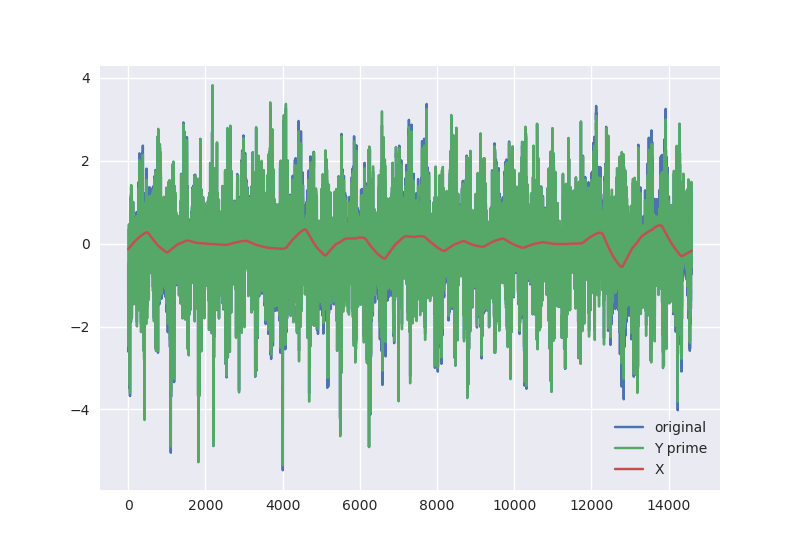

In [378]:
%matplotlib notebook
# test = np.convolve( precursor, mod_target)
# # test = np.array([min(i, target.min())])
plt.plot(target, label='original')
plt.plot(mod_target, label='Y prime')
plt.plot(x, label='X')
plt.legend(loc=0)
plt.show()

$$Y^{'} = A_1 + \cdots + A_6 + \gamma X_t(A_7) $$
$$ CAE = Y^{'} vs X $$

In [54]:
def evaluate_data_ar(data, order=2, method='mle'):
    return yule_walker(data, order, method)

In [55]:
p_ar, p_const = evaluate_data_ar(precursor)

mod_t_ar, mod_t_const = evaluate_data_ar(mod_target)

t_ar, t_const = evaluate_data_ar(target)

In [58]:
def construct_polynoom(ar, const, data, sigma, yule_walker= True):
    N =  len(data)
    epsilon = np.random.normal(loc=0, scale= sigma, size=N)
    simul_data = np.zeros(N)
    simul_data[0] = const + epsilon[0]
    ar_0, ar_1 = ar[0], ar[1]
    simul_data[1] =  const + ar_0 * simul_data[0] + epsilon[1]
    for i in range(2, N):
        simul_data[i] = const + (ar_0 * simul_data[i -1]) + (ar_1 * simul_data[i - 2]) + epsilon[i]
    print('[INFO] Polynomial fit done without dependance.')
    if yule_walker == True:
        print('[INFO] Yule walker standardisation')
        simul = np.array([(i - np.mean(simul_data))/(np.std(simul_data)) for i in simul_data])    
        return simul 
    else:
        return simul_data

In [206]:
def construct_polynoom_dependance(ar, const, data, sigma, gamma, X, yule_walker=True):
    N =  len(data)
    epsilon = np.random.normal(loc=0, scale= sigma, size=N)
    simul_data = np.zeros(N)
    simul_data[0] = const + epsilon[0]
    ar_0, ar_1 = ar[0], ar[1]
    simul_data[1] =  const + ar_0 * simul_data[0] + epsilon[1] + gamma * X[0]
    for i in range(2, N):
#         TODO EITHER ALIGN HERE OR ALIGN BEFORE ENTERING THIS FUNCTION
        if i < len(X):
            simul_data[i] = const + ( ar_0 * simul_data[i -1]) + ( ar_1 * simul_data[i - 2])+ epsilon[i] + (gamma * X[i  -1])
        else:
            simul_data[i] = const + ( ar_0 * simul_data[i -1]) + ( ar_1 * simul_data[i - 2])+ epsilon[i]
    print('[INFO] Polynomial fit done with dependance.')
    if yule_walker == True:
        print('[INFO] Yule walker standardisation')
        simul = np.array([(i - np.mean(simul_data))/(np.std(simul_data)) for i in simul_data])    
        return simul 
    else:
        return simul_data

In [60]:
def construct_polynoom_precursor(ar, const, data, sigma, nu, yule_walker=True):
    N =  len(data)
    epsilon = np.random.normal(loc=0, scale= sigma, size=N)
    simul_data = np.zeros(N)
    simul_data[0] = const + epsilon[0]
    ar_0, ar_1 = ar[0], ar[1]
    simul_data[1] =  const + (nu *ar_0 * simul_data[0] ) + epsilon[1]
    for i in range(2, N):
        simul_data[i] = const + (nu *(ar_0 * simul_data[i -1])) + (nu *(ar_1 * simul_data[i - 2])) + epsilon[i]
    print('[INFO] Polynomial fit done for precursor.')
    if yule_walker == True:
        print('[INFO] Yule walker standardisation')
        simul = np.array([(i - np.mean(simul_data))/(np.std(simul_data)) for i in simul_data])    
        return simul 
    else:
        return simul_data

In [61]:
t_poly = construct_polynoom(ar=t_ar, const=t_const,data=target, sigma=target.std())

_, t_poly = sd.postprocess_ts(serie=t_poly, regression='ct', col=target_col, debug=False)

X_pre = construct_polynoom_precursor(ar=p_ar, const=p_const, data=precursor, nu=1.0, sigma=precursor.std())

_, X_pre = sd.postprocess_ts(serie=X_pre, regression='ct', col=prec_col, debug=False)

mod_t_poly = construct_polynoom_dependance(ar=mod_t_ar, const=mod_t_const, data=mod_target, sigma=mod_target.std(), gamma=1.0, X=X_pre)

_ ,mod_t_poly = sd.postprocess_ts(serie=mod_t_poly, regression='ct', col='Mod target', debug=False)

[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation


# Create Causal effect network

## Set up in RGCPD format

In [75]:
def set_up_rgcpd_format(precursor, target, col=['mod_3ts', '3ts'], period=('06-01', '08-31'), index=rg_index):
    mod_target_df  = pd.DataFrame(data=precursor, index=pd.MultiIndex.from_product(([0], index)), columns=[col[0]])
    poly_target_df = pd.DataFrame(data=target, index= pd.MultiIndex.from_product(([0], index)), columns=[col[1]])
    dates = core_pp.get_subdates(dates=index, start_end_date=period, start_end_year=None, lpyr=False)
    RV_mask = pd.Series(np.array([True if d in dates else False for d in rg_index]), index=pd.MultiIndex.from_product(([0], index)), name='RV_mask')
    trainIsTrue = pd.Series(np.array([True for _ in range(len(target))]), index=pd.MultiIndex.from_product(([0], index)), name='TrainIsTrue')
    return pd.concat([poly_target_df, mod_target_df, trainIsTrue, RV_mask], axis=1)

In [76]:
rgcpd_formatted = set_up_rgcpd_format(precursor=mod_t_poly, target=t_poly)

## Create MCI

In [ ]:
# base_pmatrix = rg.pcmci_results_dict[0]['p_matrix']
# mask_base_pmatrix = base_pmatrix < 0.05

In [85]:
def create_mci(dFrame,rg, tau_max, pc_alpha=0.05, debug=False):
    obj_rgcpd = []
    obj_pmatrix = []
    rg.df_data = dFrame
    rg.PCMCI_df_data(tau_max=tau_max, pc_alpha=pc_alpha)
    rg.PCMCI_get_links()
    rg.df_MCIc
    obj_rgcpd.append(deepcopy(rg.df_MCIc))
    obj_pmatrix.append(deepcopy(rg.pcmci_results_dict[0]['p_matrix']))
    if debug == True:
        rg.PCMCI_plot_graph()
        plt.show()
    return obj_rgcpd, obj_pmatrix

In [94]:
def per_level_mci(cA, cA_t, rg_index, tau_max=2, pc_alpha=0.05, debug=False):
    obj_rgcpd = []
    obj_pmatrix = []
    for i in range(0,len(cA)):    
        idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,end=rg_index[-1], periods=len(cA_t[i]) ).strftime('%Y-%m-%d') )
        idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cA[i]) ).strftime('%Y-%m-%d') )
        dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-01', '08-31'), start_end_year=None, lpyr=False)
        full_time  = idx_lvl_t
        RV_time  = dates
        RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
        trainIsTrue = pd.Series(np.array([True for _ in range(len(cA_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
        ts_ca1 = pd.Series(cA[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
        ts_tca1 = pd.Series(cA_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
        df = pd.concat([ts_tca1, ts_ca1, trainIsTrue, RV_mask], axis=1)
        rg.df_data = df
        rg.PCMCI_df_data(tau_max=tau_max, pc_alpha=pc_alpha)
        rg.PCMCI_get_links()
        rg.df_MCIc
        obj_rgcpd.append(deepcopy(rg.df_MCIc))
        obj_pmatrix.append(deepcopy(rg.pcmci_results_dict[0]['p_matrix']))
        if debug == True:
            rg.PCMCI_plot_graph()
            plt.show()
    return obj_rgcpd, obj_pmatrix

In [82]:
def extract_mci_lags(to_clean_mci_df, lag=0):
    lag_target = [lags.values[:,lag][1] for _, lags in enumerate(to_clean_mci_df)]
    lag_precurs = [lags.values[:,lag][1] for _, lags in enumerate(to_clean_mci_df)]
    return lag_target, lag_precurs

In [95]:
_, cD_t =  decompose_signal(data=t_poly, w=la8, mode=wv.Modes.periodic, level=15, debug=False)
_, cD_p =  decompose_signal(data=mod_t_poly, w=la8, mode=wv.Modes.periodic, level=15, debug=False)

Appropriate level is changed to 11
Appropriate level is changed to 11


Progress causal inference - traintest set 100%

/home/jier/miniconda3/envs/RGCPD/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


<IPython.core.display.Javascript object>


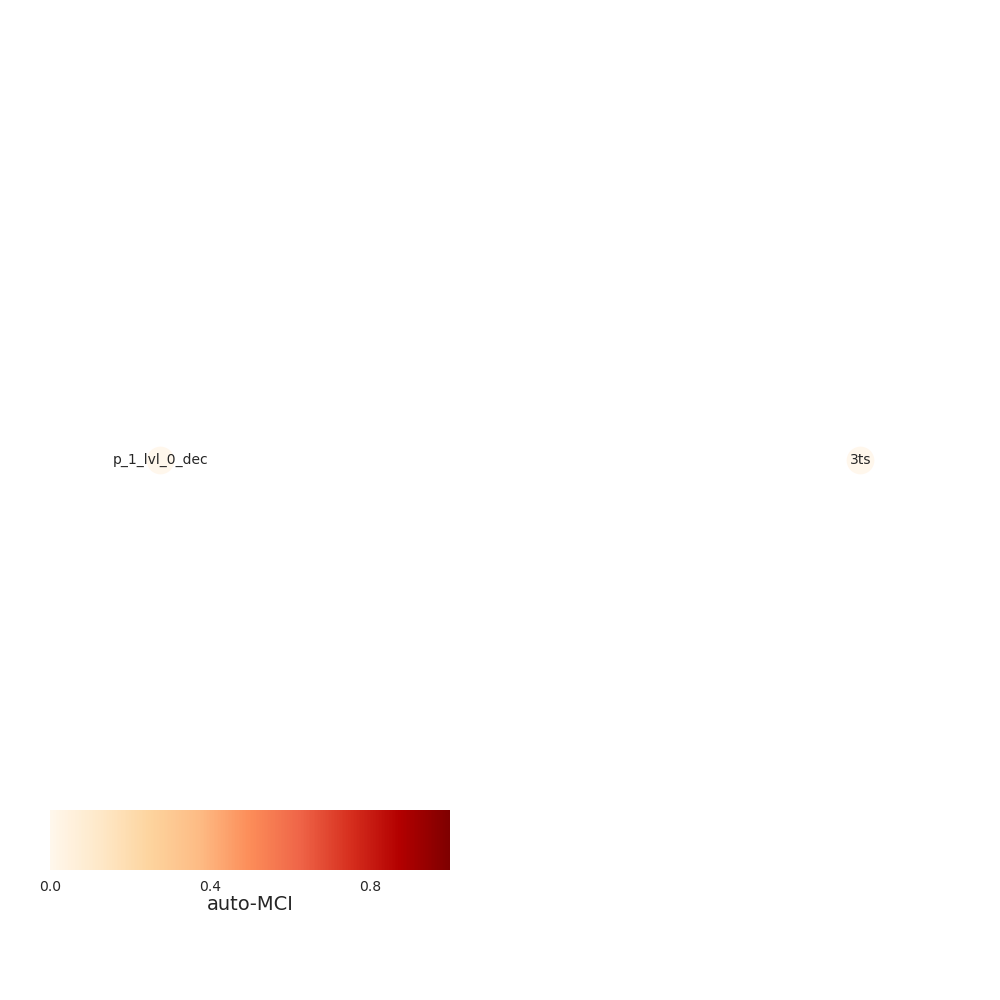

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


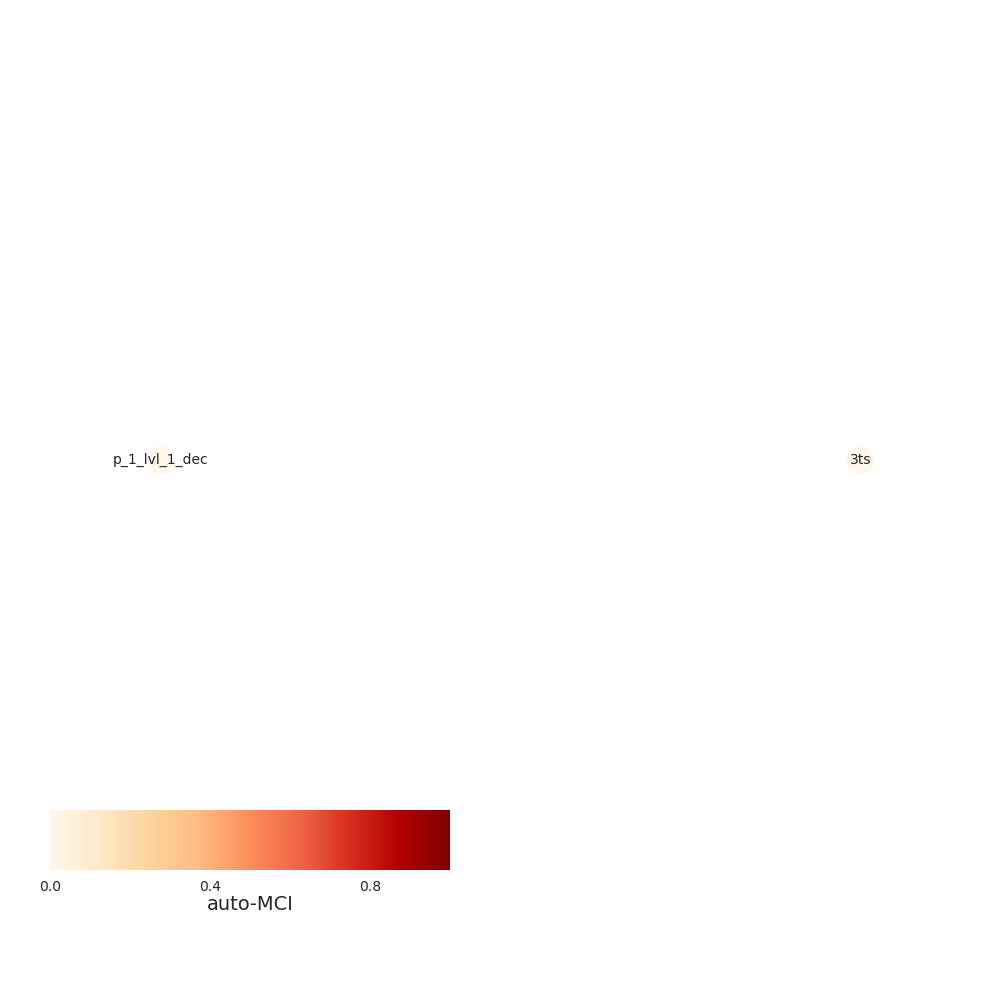

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


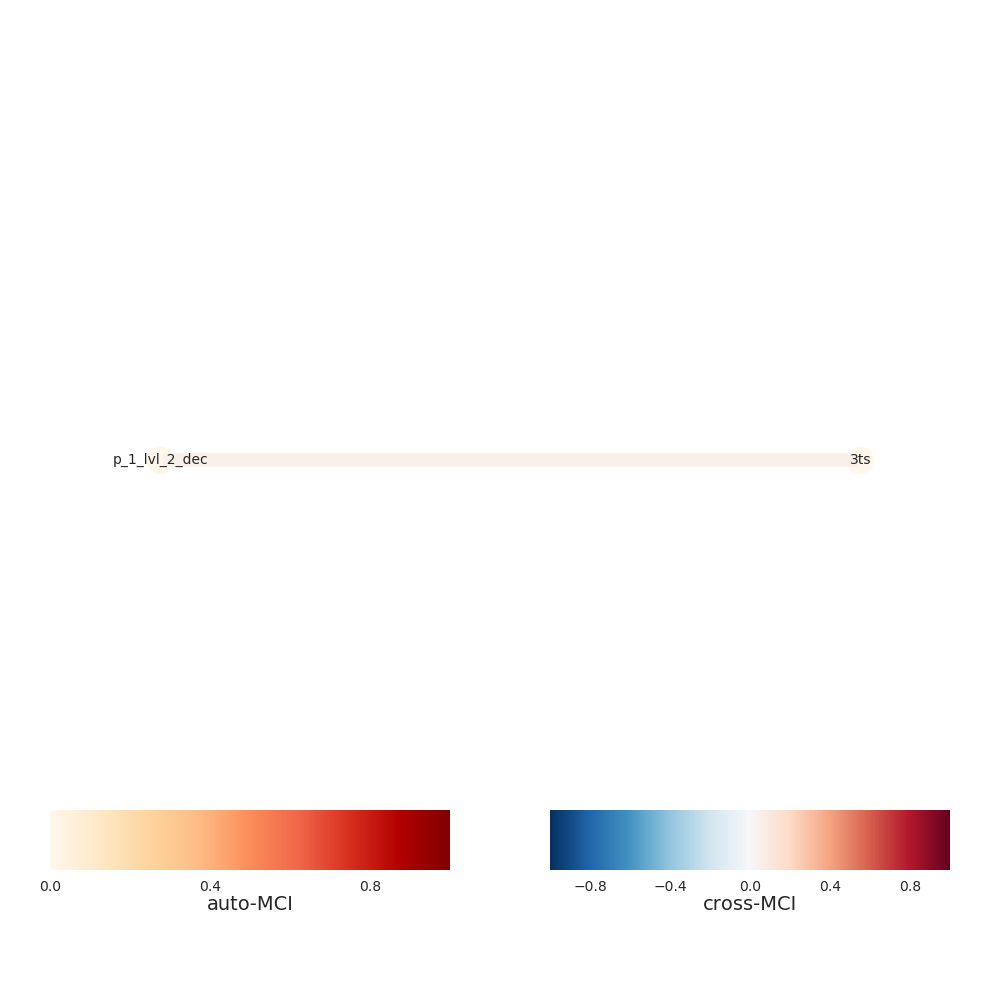

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


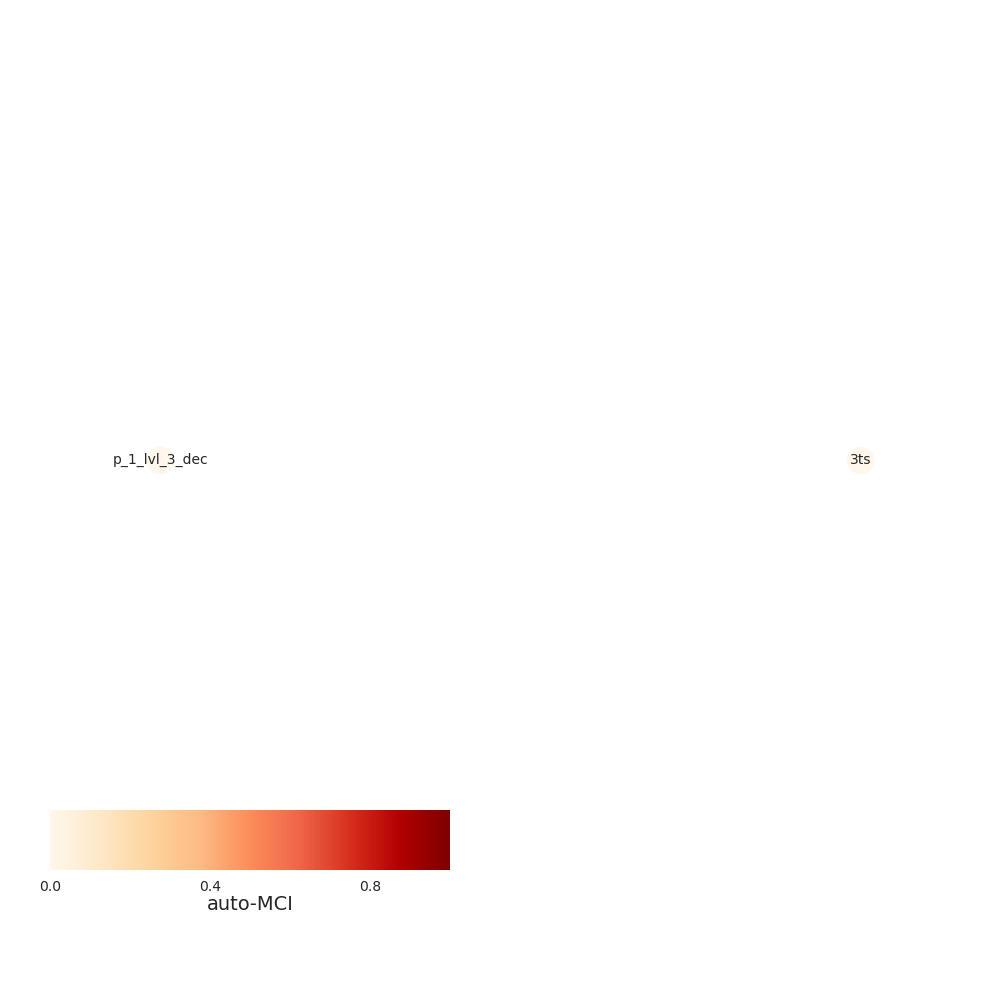

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


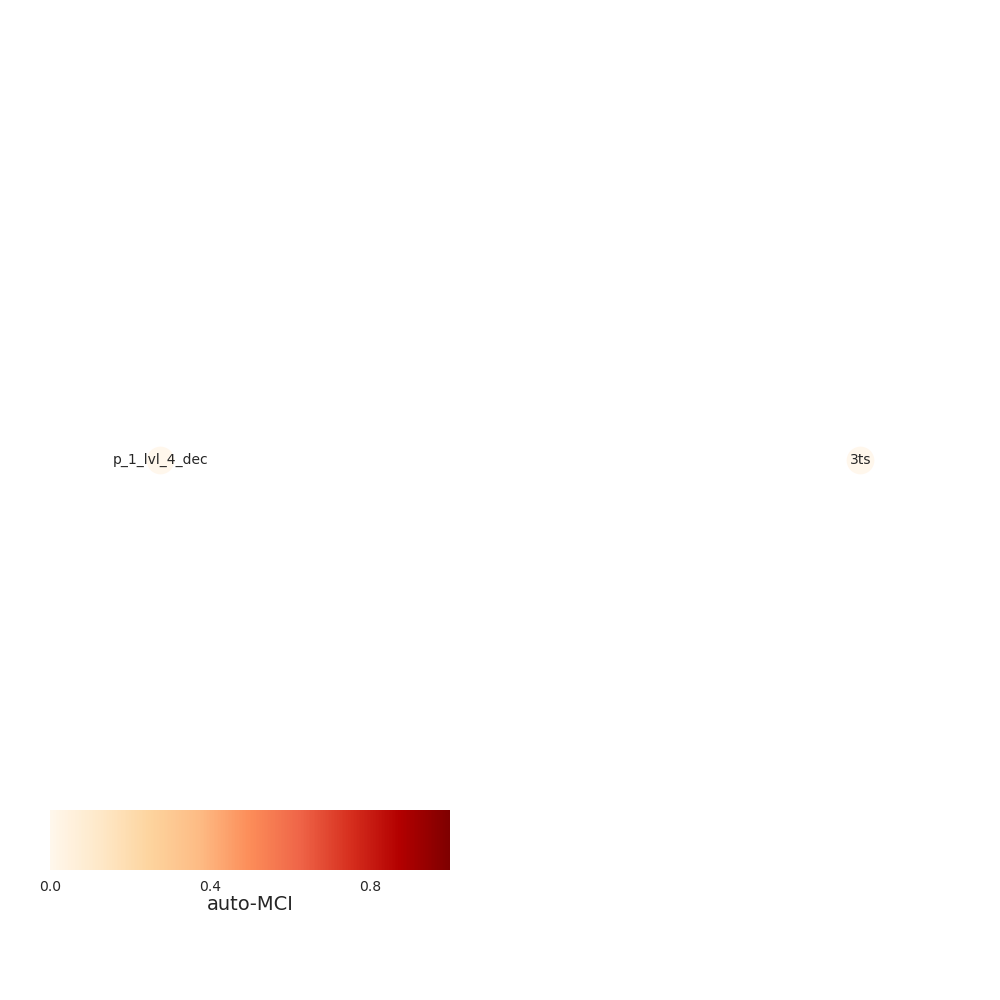

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


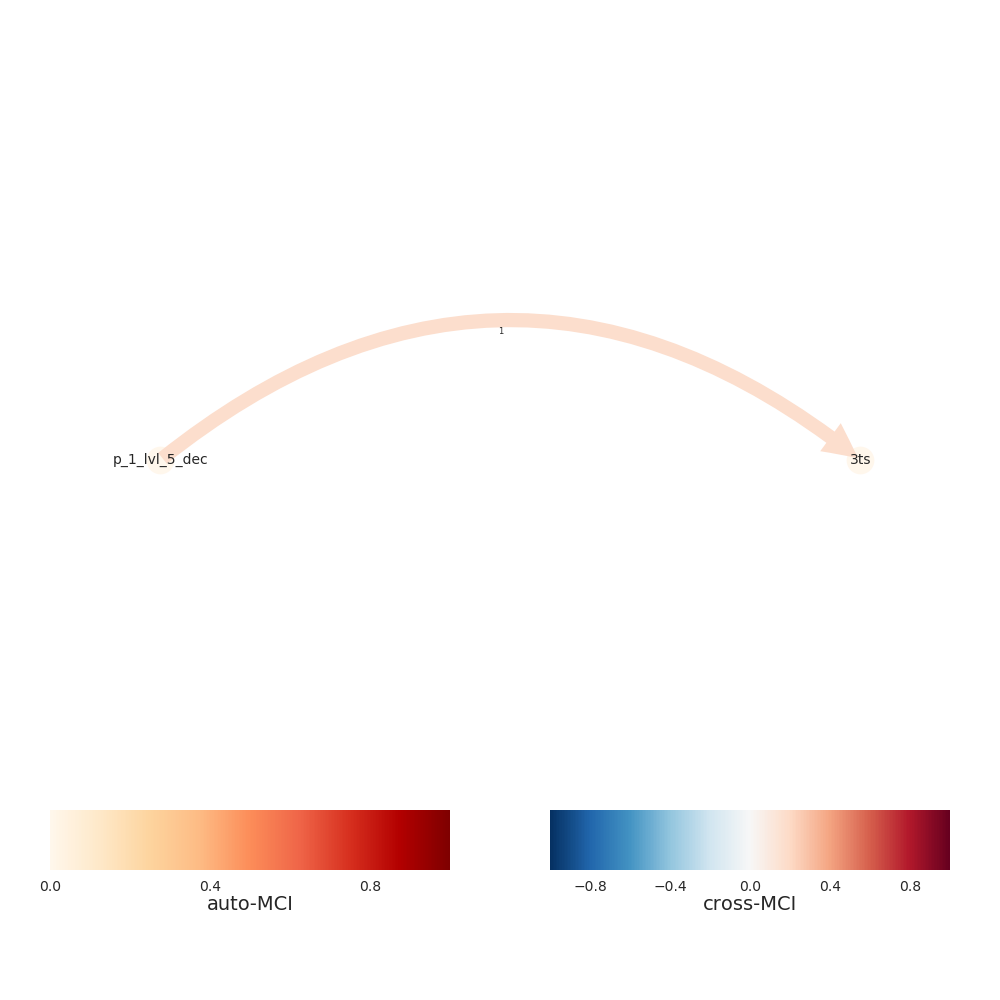

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


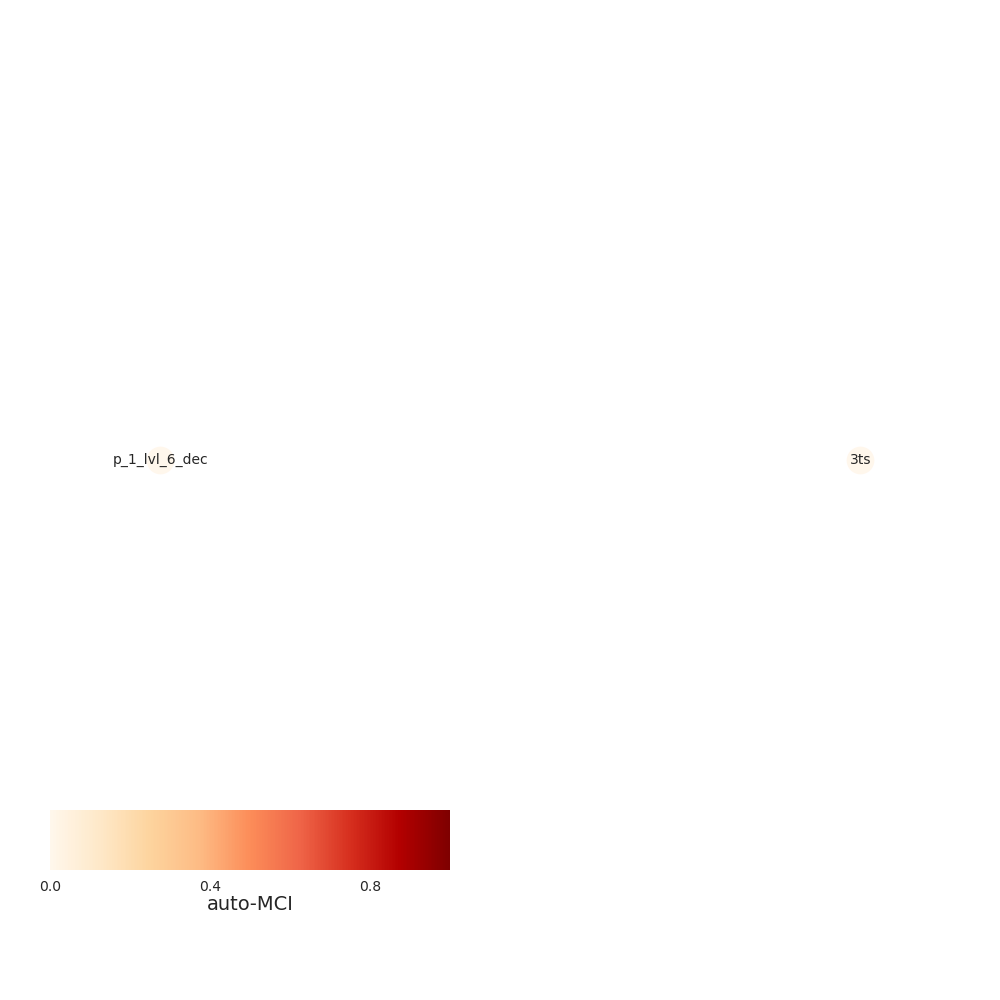

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


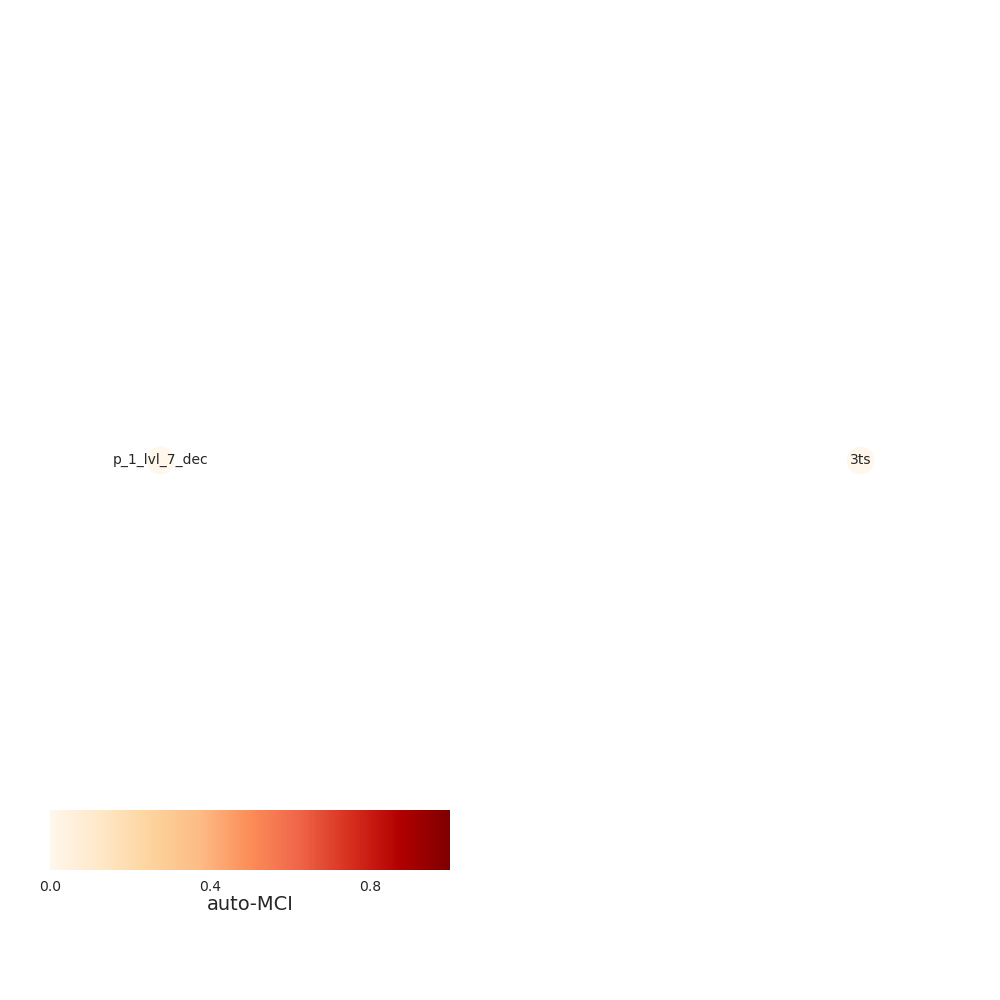

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


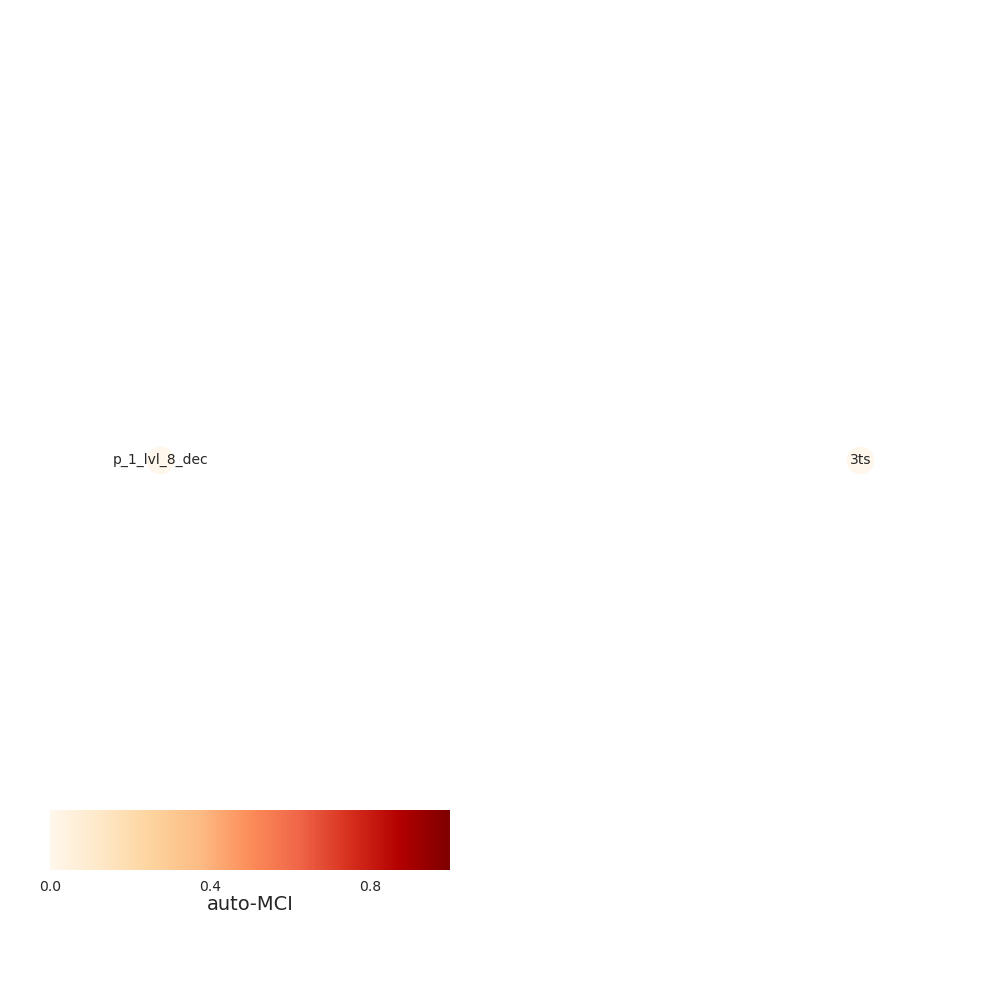

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


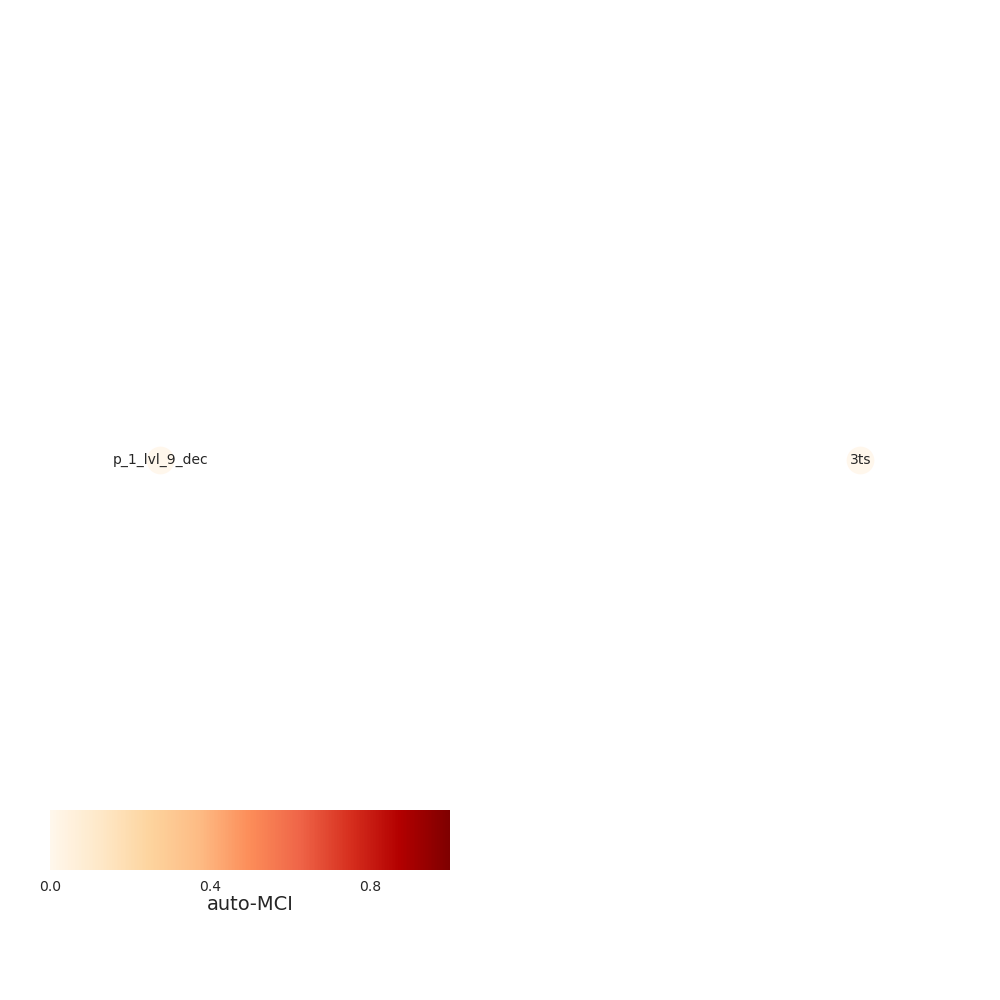

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


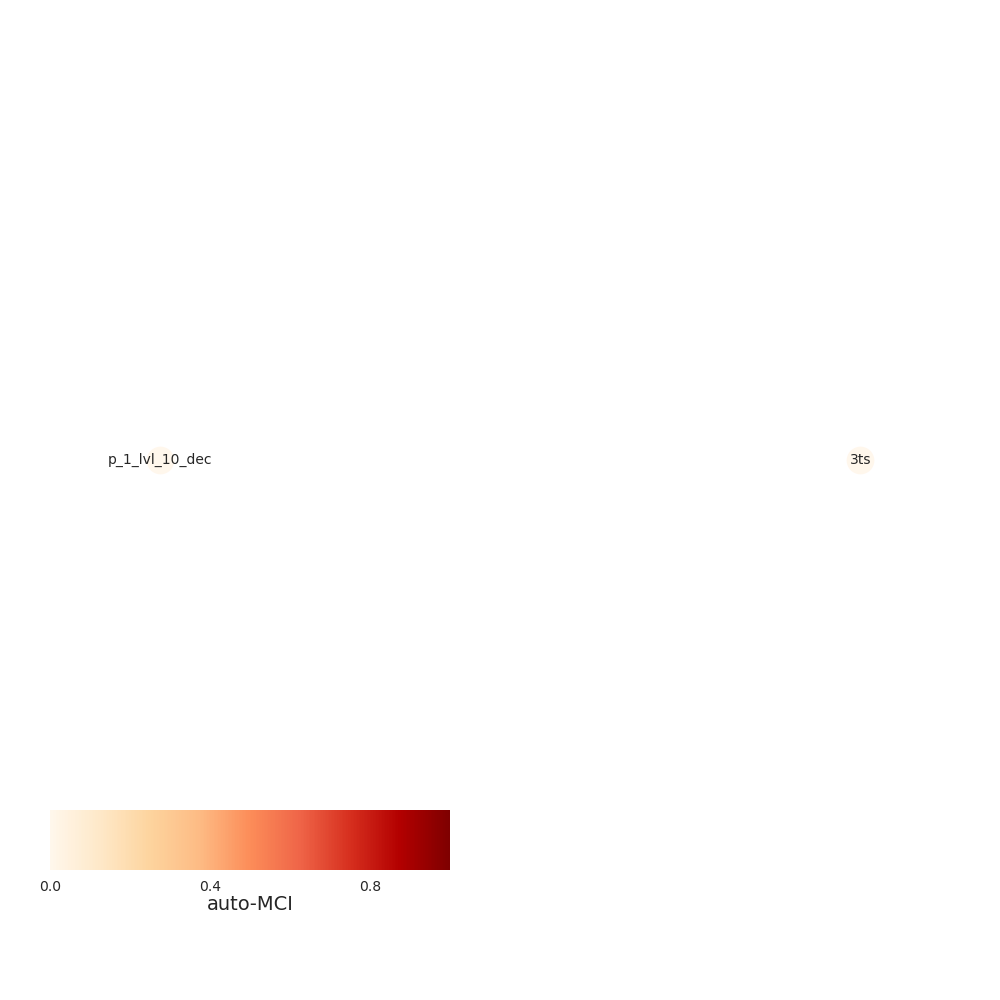

In [96]:
mci_peaks, mci_p_matrix = per_level_mci(cA=cD_p, cA_t=cD_t, rg_index=rg_index, debug=True)

In [86]:
# mci_peaks, mci_p_matrix = create_mci(dFrame=rgcpd_formatted, rg=rg, tau_max=2)

Progress causal inference - traintest set 100%

In [98]:
_, lag_precursor = extract_mci_lags(to_clean_mci_df=mci_peaks)

### Visualize MCI

In [104]:
def plot_mci_pred_relation(cA, prec_lag, path, title, savefig=False):
    x_as = np.arange(1, len(cA)+1)
    x_as = np.exp2(x_as)
    plt.figure(dpi=120)
    plt.plot(x_as, prec_lag, label='precrursor ')
    plt.vlines(x_as[np.argmax(prec_lag)], ymin=plt.ylim()[0], ymax=plt.ylim()[1],linestyles='dashed', label='MCI peak')
    plt.xscale('log', basex=2)
    plt.xticks(x_as, [str(2**i)+' days' for i in range(1, len(prec_lag)+1)], rotation=45) 
    plt.title(title)
    plt.xlabel('Scales in daily means')
    plt.ylabel('MCI')
    plt.legend(loc=0)
    if savefig ==True:
        Path('Wavelet/Mci/'+path).mkdir(parents=True, exist_ok=True)
        plt.savefig('Wavelet/Mci/'+path+'/MCI on scale wavelet on lag 0 of '+str(title)+' iteration.pdf', dpi=120)
        # plt.savefig('Wavelet/Mci/'+path+'/MCI on scale wavelet on lag 0 of '+str(title)+' iteration.png', dpi=120)
        plt.clf()
        plt.close()
    else:
        plt.show()

<IPython.core.display.Javascript object>


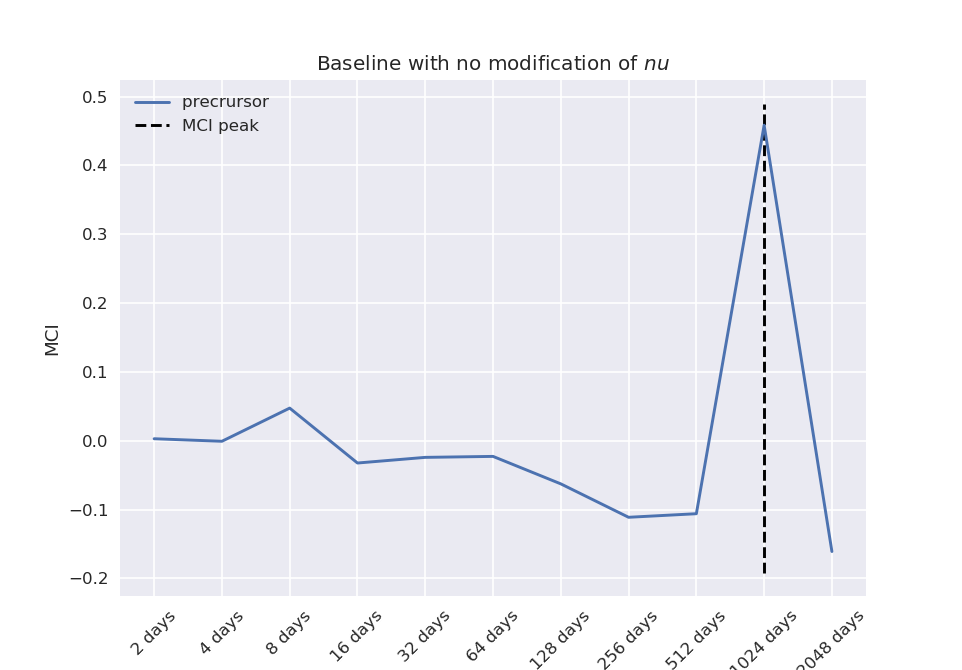

In [105]:
plot_mci_pred_relation(cA=cD_t, prec_lag=lag_precursor, path='Baseline', title=r'Baseline with no modification of $nu$' )

# Variations of nu for last level decomposition

## Set up variation on nu

In [118]:
def prepare_ar_for_experiment(t_ca, t_cd, target, prec_level, depth=level,to_omit_depth=len(levels), w=la8, mode=wv.Modes.periodic):
    
    precursor = get_precursor_from_target_decomposition(t_ca, t_cd, target, prec_level, w, wv.Modes.periodic)
    mod_target = build_up_to_level(data=target, w=w, mode=mode, level=depth, to_omit_level=to_omit_depth)
    p_ar, p_const = evaluate_data_ar(precursor)
    mod_t_ar, mod_t_const = evaluate_data_ar(mod_target)
    t_ar, t_const = evaluate_data_ar(target)
    return (t_ar, t_const), (mod_t_ar, mod_t_const), (p_ar, p_const)

In [114]:
def construct_polynomes(t_ar, t_const, target, mod_t_ar, mod_t_const, p_ar, p_const, nu=1.0, gamma=1.0, debug=False):
    
    t_poly = construct_polynoom(ar=t_ar, const=t_const,data=target, sigma=target.std())
    _, t_poly = sd.postprocess_ts(serie=t_poly, regression='ct', col=target_col, debug=False)
    X_pre = construct_polynoom_precursor(ar=p_ar, const=p_const, data=precursor, nu=nu, sigma=precursor.std())
    _, X_pre = sd.postprocess_ts(serie=X_pre, regression='ct', col=prec_col, debug=False)
    mod_t_poly = construct_polynoom_dependance(ar=mod_t_ar, const=mod_t_const, data=mod_target, sigma=mod_target.std(), gamma=gamma, X=X_pre)
    _ ,mod_t_poly = sd.postprocess_ts(serie=mod_t_poly, regression='ct', col='Mod target', debug=False)
    return t_poly, mod_t_poly

In [124]:
def extract_coeffs_from_polynome(t_poly, mod_t_poly, depth=level, w=la8, mode=wv.Modes.periodic, debug=False):
    _, cD_t, _ =  decompose_signal(data=t_poly, w=w, mode=mode, level=level, debug=False)
    _, cD_p, _ =  decompose_signal(data=mod_t_poly, w=w, mode=mode, level=level, debug=False)
    return cD_t, cD_p

In [117]:
def causal_effect_network_mci(cD_p, cD_t, index=rg_index, debug=False):
    mci_peaks, mci_p_matrix = per_level_mci(cA=cD_p, cA_t=cD_t, rg_index=index, debug=debug)
    _, lag_precursor = extract_mci_lags(to_clean_mci_df=mci_peaks)
    return lag_precursor, mci_p_matrix

## Run experiments for last level

In [143]:
gammas = np.arange(0.1, 1.1, 0.1)
nus = np.arange(0.1, 1.1, 0.1)
tests = ['avg', 'perc', 'var']
elements = ['wvar', 'dep', 'mci']
experiments = nus
iteration = 10
daily_mean_peak = np.empty((iteration, len(experiments)))
exp_col =  {key: daily_mean_peak for key in ['mod_3ts', '3ts']}
exper_results = {'mod_3ts':daily_mean_peak}
# p_values_mci = {'mod_3ts':np.empty((iteration, len(experiments)))}
p_values_mci = []
t_ca, t_cd, level = decompose_signal(data=target, w=la8, mode=wv.Modes.periodic, level=15)
levels = np.arange(level)

Appropriate level is changed to 11


In [119]:
(t_ar, t_const), (mod_t_ar, mod_t_const), (p_ar, p_const) = prepare_ar_for_experiment(t_ca, t_cd, target, prec_level=level-1, depth=level,to_omit_depth=len(levels), w=la8, mode=wv.Modes.periodic)

[INFO] Know that to_omit_level needs to be 1 indexed instead of 0 indexed
[INFO] Length decomposed coefficients is 12


In [130]:
def run_experiments(experiments,t_ar, t_const, target, mod_t_ar, mod_t_const, p_ar, p_const,rg_index, p_values_mci, exper_results ):
    for exp in experiments: # all xis [0.1, .... 1]
    #     poly_stats ={key:[] for key in elements} 
    #     poly_stats_iter ={key:{key: [] for  key in tests} for key in elements} 
        # for-loop iteratie for consistency
        for it in np.arange(0, iteration): #all experiments M = end_iter+1
            t_poly, mod_t_poly = construct_polynomes(t_ar, t_const, target, mod_t_ar, mod_t_const, p_ar, p_const, nu=exp, gamma=1.0, debug=False)
            cD_t, cD_p = extract_coeffs_from_polynome(t_poly, mod_t_poly, depth=level, w=la8, mode=wv.Modes.periodic, debug=False)
            lag_precursor, mci_p_matrix = causal_effect_network_mci(cD_p, cD_t, index=rg_index, debug=False)
            day_means_scales = np.arange(1, len(cD_p)+1)
            day_means_scales = np.exp2(day_means_scales).astype(np.float64)
            #  This will be the holy grail for boxplot
            exper_results['mod_3ts'][it,np.argwhere(experiments==exp)[0][0]] = day_means_scales[np.argmax(lag_precursor)]
            p_values_mci.append(mci_p_matrix)
    return exper_results, p_values_mci
        

In [150]:
import multiprocessing as mp
p = mp.Pool(mp.cpu_count()-1)
res = None
values = [(experiments,t_ar, t_const, target, mod_t_ar, mod_t_const, p_ar, p_const,rg_index, p_values_mci, exper_results)]
res = p.starmap(run_experiments, values )


[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.



/home/jier/miniconda3/envs/RGCPD/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is NOT stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] Detrend polynome of precursor to force trend stationarity
[INFO] Result ADF: The serie is NOT stationary
[INFO] Result KPSS: The trend of the serie is stationary
[WARNING] Still not trend stationarity solved
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Resul

[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[

[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100

[INFO] Detrend polynome of precursor to force trend stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] Differencing succes, ADF and KPSS Stationarity passed.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[IN


[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is NOT stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] Detrend polynome of precursor to force trend stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] Differencing succes, ADF and KPSS Stationarity passed.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationar


[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is NOT stationary
[INFO] Detrend polynome of Mod target to force trend stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is NOT stationary
[WARNING] Still not trend stationarity solved
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is N

[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postpro

[INFO] Result ADF: The serie is NOT stationary
[INFO] Result KPSS: The trend of the serie is stationary
[WARNING] Still not trend stationarity solved
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is NOT stationary
[INFO] Detrend polynome of Mod target to force trend stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is NOT stationary
[WARNING] Still not trend stationarity solved
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO]

[INFO] Differencing succes, ADF and KPSS Stationarity passed.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit don

[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is NOT stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] Detrend polynome of precursor to force trend stationarity
[INFO] Result ADF: The serie is NOT stationary
[INFO] Result KPSS: The trend of the serie is stationary
[WARNING] Still not trend stationarity solved
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Resu

[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stat

[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done with dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100


[INFO] Postprocess Polynome of 'Mod target' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is NOT stationary
[INFO] Detrend polynome of Mod target to force trend stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is NOT stationary
[WARNING] Still not trend stationarity solved
[INFO] No differencing, Postprocess done.

Progress causal inference - traintest set 100%[INFO] Polynomial fit done without dependance.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of '3ts' to examine stationarity
[INFO] Result ADF: The serie is stationary
[INFO] Result KPSS: The trend of the serie is stationary
[INFO] No differencing, Postprocess done.

[INFO] Polynomial fit done for precursor.
[INFO] Yule walker standardisation

[INFO] Postprocess Polynome of 'precursor' to examine stationarity
[INFO] Result ADF: The serie is NOT stationary
[INFO] Result KPSS: The trend of the serie 

In [192]:
result, p_values = res[0][0], res[0][1]

### Visualize experiments

In [201]:
def box_plot_reesult_experiments(result, level, title=r'Evaluation of sensitivity $\nu$ on modified target baseline'):
    df = pd.DataFrame(result['mod_3ts'])

    kwargs ={ 'meanline':True, 'showmeans':True} 
    df.boxplot(figsize=(16, 8), **kwargs)
    plt.ylabel(r'MCI Peaks at level of decomposition ')
    plt.xlabel(r'Variation $\nu$')
    plt.yscale('log',basey=2) 
    plt.yticks(np.exp2(np.arange(1, level +1)), [str(2**i)+' days' for i in range(1, level+1)], rotation=45)
    plt.title(title)
    plt.show()

<IPython.core.display.Javascript object>


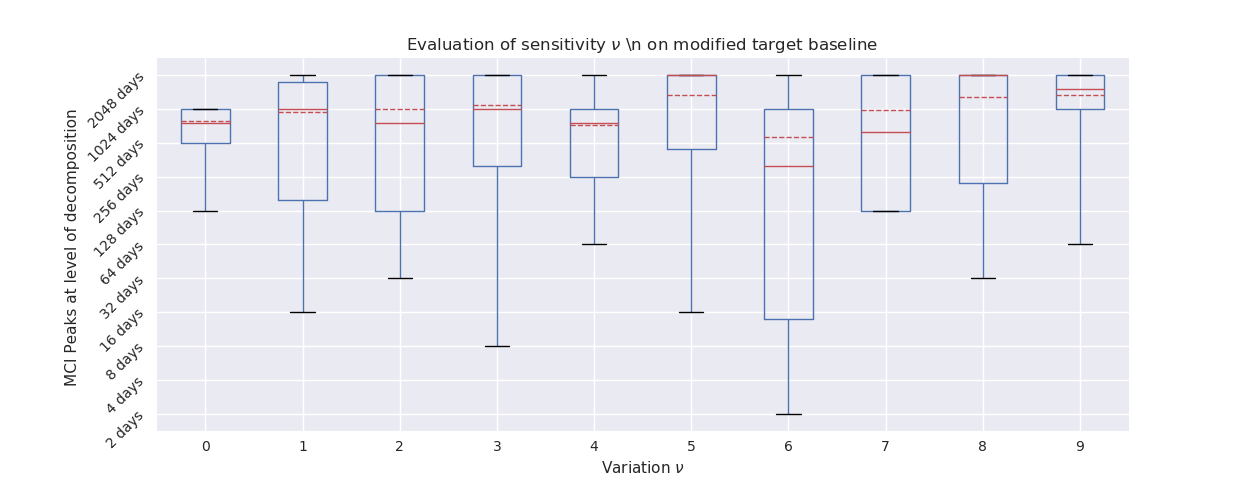

In [205]:
box_plot_reesult_experiments(result, level=level)

In [203]:
p_values[0]

[array([[[1.00000000e+000, 3.10936023e-154, 7.42865769e-001],
         [8.65475780e-002, 9.30884022e-001, 6.59339497e-002]],
 
        [[8.65475780e-002, 8.94160794e-001, 4.77684120e-001],
         [1.00000000e+000, 7.34489197e-135, 2.85241880e-001]]]),
 array([[[1.00000000e+000, 1.33875054e-167, 1.16023333e-005],
         [7.13169478e-001, 3.49342353e-001, 3.42923618e-001]],
 
        [[7.13169478e-001, 7.77484174e-001, 7.96840121e-001],
         [1.00000000e+000, 8.07597741e-157, 3.92077929e-004]]]),
 array([[[1.00000000e+00, 1.65403521e-29, 2.05105776e-02],
         [4.44421007e-01, 7.10348815e-01, 9.35938092e-01]],
 
        [[4.44421007e-01, 3.60535334e-01, 5.22481564e-01],
         [1.00000000e+00, 4.50114253e-27, 7.66626578e-01]]]),
 array([[[1.        , 0.02683513, 0.14807295],
         [0.61122138, 0.83367535, 0.33727266]],
 
        [[0.61122138, 0.79541476, 0.51357309],
         [1.        , 0.32527251, 0.48083337]]]),
 array([[[1.        , 0.27631877, 0.41055795],
         